In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR

Notes on Specific Variables
- Rooms: Number of rooms

- Price: Price in dollars

- Method: S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.

- Type: br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.

- SellerG: Real Estate Agent

- Date: Date sold

- Distance: Distance from CBD

- Regionname: General Region (West, North West, North, North east …etc)

- Propertycount: Number of properties that exist in the suburb.

- Bedroom2 : Scraped # of Bedrooms (from different source)

- Bathroom: Number of Bathrooms

- Car: Number of carspots

- Landsize: Land Size

- BuildingArea: Building Size

- CouncilArea: Governing council for the area

In [2]:
# ingest data
df = pd.read_csv("melb_data.csv")
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [3]:
df.shape

(13580, 21)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

In [5]:
df.isna().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

In [6]:
df.columns = df.columns.str.lower()

In [7]:
# analyzing the property type 
df['type'].value_counts()

type
h    9449
u    3017
t    1114
Name: count, dtype: int64

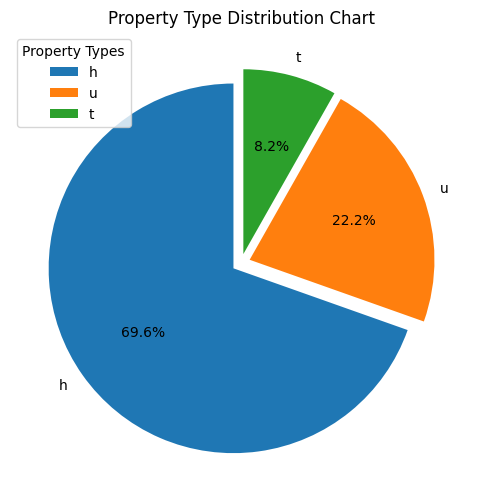

In [8]:
# Count the property types
counts = df['type'].value_counts()
labels = counts.index 

# Create explode array 
explode = [0.05] * len(counts)

plt.figure(figsize=[6,6])

plt.pie(
    counts,
    labels=labels,
    explode=explode,
    autopct='%1.1f%%',   # show percentages
    startangle=90        # rotate so first slice starts at top
)
plt.title("Property Type Distribution Chart")
plt.legend(labels, title="Property Types", loc="best")
plt.show()

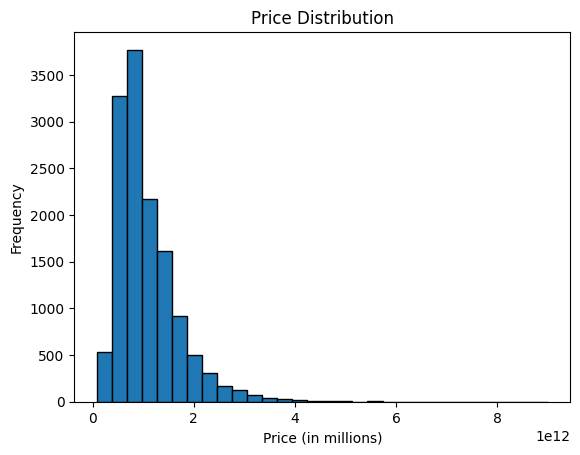

In [9]:
# Analyze the target variable
plt.hist(df["price"] * 1_000_000, bins=30, edgecolor="black")
plt.xlabel("Price (in millions)")
plt.ylabel("Frequency")
plt.title("Price Distribution")
plt.show()

In [10]:
df.columns
df = df.rename(columns={"longtitude": "longitude", "lattitude": "latitude"})

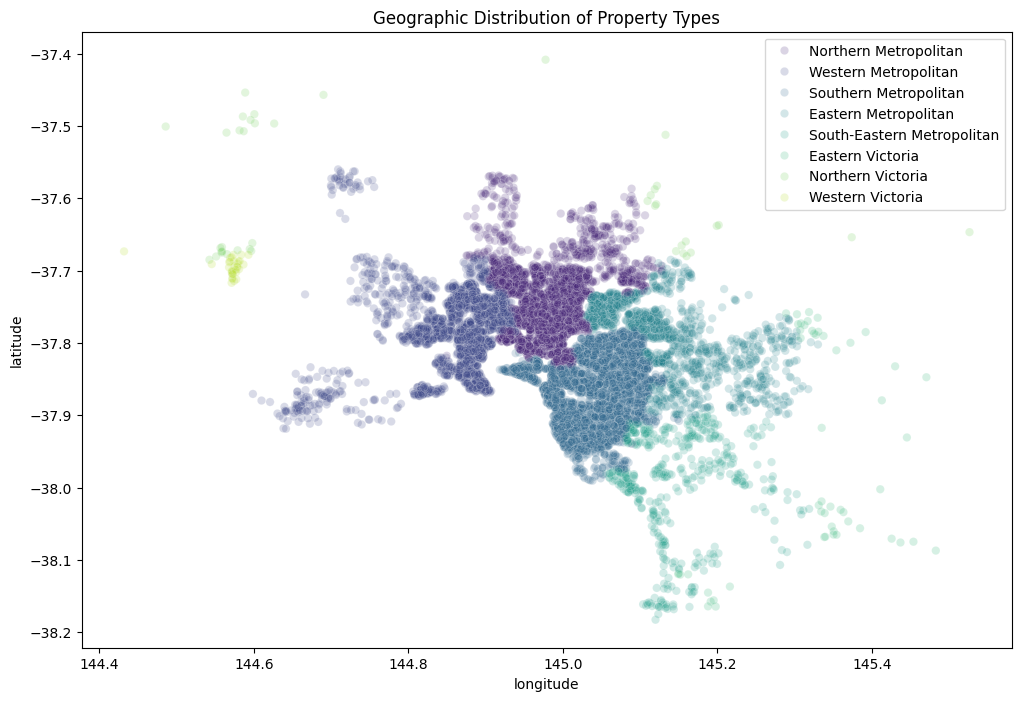

In [11]:

plt.figure(figsize=[12, 8])
sns.scatterplot(
    data=df,
    x="longitude",
    y="latitude",
    hue="regionname",
    alpha=0.2,
    palette= "viridis"
)
plt.legend()
plt.title("Geographic Distribution of Property Types")
plt.show()

In [12]:
cat_features = df.select_dtypes(include = "object")

cat_features.columns

Index(['suburb', 'address', 'type', 'method', 'sellerg', 'date', 'councilarea',
       'regionname'],
      dtype='object')

In [13]:
cat_features.nunique()

suburb           314
address        13378
type               3
method             5
sellerg          268
date              58
councilarea       33
regionname         8
dtype: int64

In [14]:
num_features = df.select_dtypes(exclude= "object")
num_features.corr()

,rooms,price,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,yearbuilt,latitude,longitude,propertycount
rooms,1.000000,0.496634,0.294203,0.055303,0.944190,0.592934,0.408483,0.025678,0.124127,-0.065413,0.015948,0.100771,-0.081530
price,0.496634,1.000000,-0.162522,0.107867,0.475951,0.467038,0.238979,0.037507,0.090981,-0.323617,-0.212934,0.203656,-0.042153
distance,0.294203,-0.162522,1.000000,0.431514,0.295927,0.127155,0.262994,0.025004,0.099481,0.246379,-0.130723,0.239425,-0.054910
postcode,0.055303,0.107867,0.431514,1.000000,0.060584,0.113664,0.050289,0.024558,0.055475,0.032863,-0.406104,0.445357,0.062304
bedroom2,0.944190,0.475951,0.295927,0.060584,1.000000,0.584685,0.405325,0.025646,0.122319,-0.053319,0.015925,0.102238,-0.081350
bathroom,0.592934,0.467038,0.127155,0.113664,0.584685,1.000000,0.322246,0.037130,0.111933,0.152702,-0.070594,0.118971,-0.052201
car,0.408483,0.238979,0.262994,0.050289,0.405325,0.322246,1.000000,0.026770,0.096101,0.104515,-0.001963,0.063395,-0.024295
landsize,0.025678,0.037507,0.025004,0.024558,0.025646,0.037130,0.026770,1.000000,0.500485,0.036451,0.009695,0.010833,-0.006854
buildingarea,0.124127,0.090981,0.099481,0.055475,0.122319,0.111933,0.096101,0.500485,1.000000,0.019665,0.043420,-0.023810,-0.028840
yearbuilt,-0.065413,-0.323617,0.246379,0.032863,-0.053319,0.152702,0.104515,0.036451,0.019665,1.000000,0.060445,-0.003470,0.006361


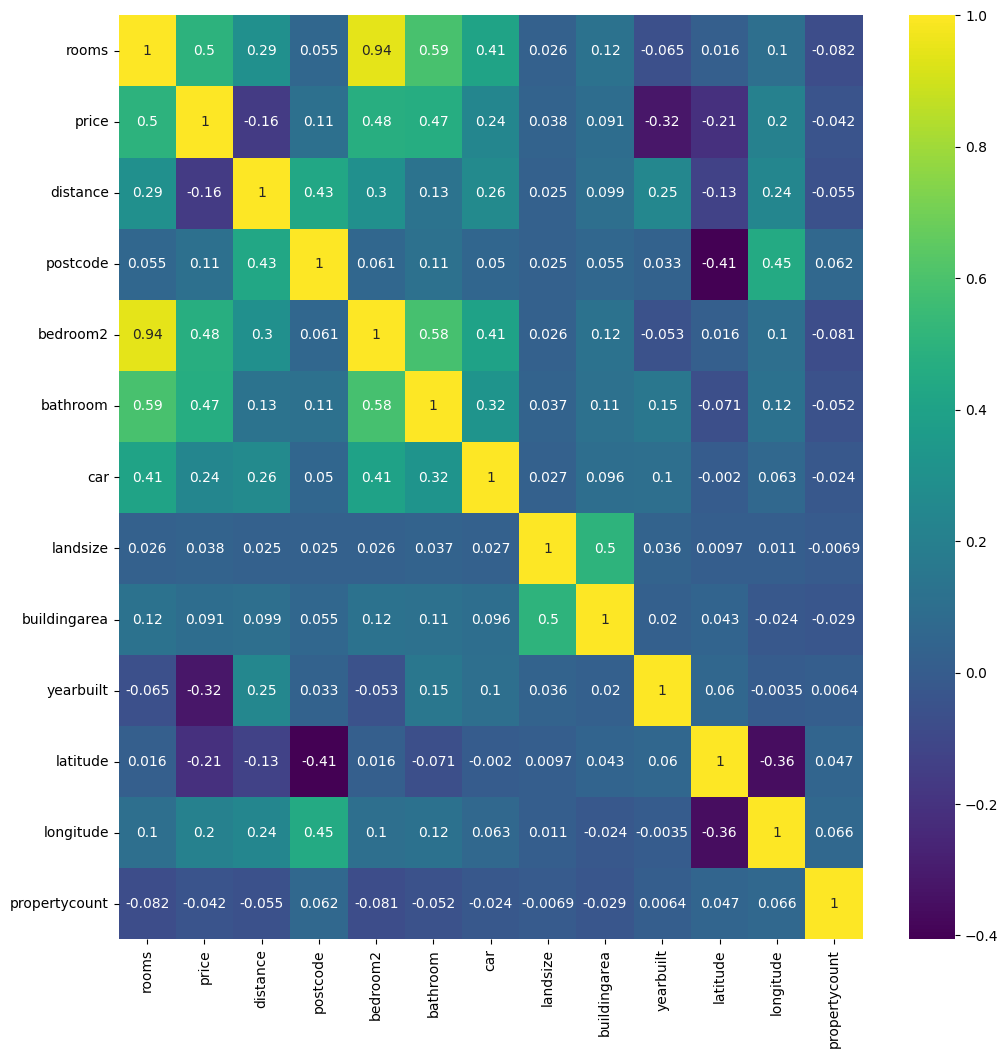

In [15]:
plt.figure(figsize= [12, 12])
sns.heatmap(
    num_features.corr(),
    annot= True,
    cmap="viridis"
)
plt.show()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   suburb         13580 non-null  object 
 1   address        13580 non-null  object 
 2   rooms          13580 non-null  int64  
 3   type           13580 non-null  object 
 4   price          13580 non-null  float64
 5   method         13580 non-null  object 
 6   sellerg        13580 non-null  object 
 7   date           13580 non-null  object 
 8   distance       13580 non-null  float64
 9   postcode       13580 non-null  float64
 10  bedroom2       13580 non-null  float64
 11  bathroom       13580 non-null  float64
 12  car            13518 non-null  float64
 13  landsize       13580 non-null  float64
 14  buildingarea   7130 non-null   float64
 15  yearbuilt      8205 non-null   float64
 16  councilarea    12211 non-null  object 
 17  latitude       13580 non-null  float64
 18  longit

In [17]:
# Drop high cardinality columns
cols_drop = ["address", "date", "sellerg", "suburb", "councilarea"]
df.drop(columns= cols_drop, inplace= True)


In [18]:
# split features and target
target = "price"
X = df.drop(columns=target)
y = df[target]

In [19]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [20]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10864 entries, 12796 to 7270
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rooms          10864 non-null  int64  
 1   type           10864 non-null  object 
 2   method         10864 non-null  object 
 3   distance       10864 non-null  float64
 4   postcode       10864 non-null  float64
 5   bedroom2       10864 non-null  float64
 6   bathroom       10864 non-null  float64
 7   car            10814 non-null  float64
 8   landsize       10864 non-null  float64
 9   buildingarea   5735 non-null   float64
 10  yearbuilt      6578 non-null   float64
 11  latitude       10864 non-null  float64
 12  longitude      10864 non-null  float64
 13  regionname     10864 non-null  object 
 14  propertycount  10864 non-null  float64
dtypes: float64(11), int64(1), object(3)
memory usage: 1.3+ MB


## Imputing, scaling and Encoding the Data


In [21]:
imputer = SimpleImputer(strategy= "median")

In [22]:
housing = X_train.copy()

In [23]:
housing_num = housing.select_dtypes(exclude= "object")
housing_cat = housing.select_dtypes(include="object")

In [24]:
imputer.fit(housing_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [25]:
housing_imputed = imputer.transform(housing_num)
housing_imputed

array([[ 4.0000000e+00,  1.4200000e+01,  3.1490000e+03, ...,
        -3.7861270e+01,  1.4514271e+02,  1.3366000e+04],
       [ 3.0000000e+00,  1.4200000e+01,  3.1490000e+03, ...,
        -3.7868380e+01,  1.4514664e+02,  1.3366000e+04],
       [ 2.0000000e+00,  4.6000000e+00,  3.1220000e+03, ...,
        -3.7818000e+01,  1.4502680e+02,  1.1308000e+04],
       ...,
       [ 3.0000000e+00,  2.6000000e+00,  3.1210000e+03, ...,
        -3.7824800e+01,  1.4499760e+02,  1.4949000e+04],
       [ 2.0000000e+00,  1.3900000e+01,  3.1650000e+03, ...,
        -3.7929300e+01,  1.4506570e+02,  1.0969000e+04],
       [ 3.0000000e+00,  8.2000000e+00,  3.0120000e+03, ...,
        -3.7791200e+01,  1.4486800e+02,  5.0580000e+03]],
      shape=(10864, 12))

In [26]:
ss = StandardScaler()

In [27]:
housing_scaled = ss.fit_transform(housing_imputed)
housing_scaled

array([[ 1.11051011,  0.69657594,  0.47639252, ..., -0.6591303 ,
         1.42232838,  1.34800983],
       [ 0.06677087,  0.69657594,  0.47639252, ..., -0.74913521,
         1.46013918,  1.34800983],
       [-0.97696836, -0.93395159,  0.18154476, ..., -0.1113789 ,
         0.30715043,  0.87803509],
       ...,
       [ 0.06677087, -1.27364483,  0.17062447, ..., -0.19745954,
         0.02621526,  1.7095113 ],
       [-0.97696836,  0.64562195,  0.65111713, ..., -1.52031652,
         0.68140996,  0.80061943],
       [ 0.06677087, -0.32250377, -1.01968689, ...,  0.22788012,
        -1.22067511, -0.54924486]], shape=(10864, 12))

In [28]:
type(housing_scaled)

numpy.ndarray

In [29]:
housing_num_tr = pd.DataFrame(housing_scaled, columns= housing_num.columns)

In [30]:
oh = OneHotEncoder()

In [31]:
housing_cat_encoded = oh.fit_transform(housing_cat)
housing_cat_encoded

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 32592 stored elements and shape (10864, 16)>

In [32]:
oh.get_feature_names_out()

array(['type_h', 'type_t', 'type_u', 'method_PI', 'method_S', 'method_SA',
       'method_SP', 'method_VB', 'regionname_Eastern Metropolitan',
       'regionname_Eastern Victoria', 'regionname_Northern Metropolitan',
       'regionname_Northern Victoria',
       'regionname_South-Eastern Metropolitan',
       'regionname_Southern Metropolitan',
       'regionname_Western Metropolitan', 'regionname_Western Victoria'],
      dtype=object)

In [33]:
housing_cat_encoded = pd.DataFrame(housing_cat_encoded.toarray(), columns= oh.get_feature_names_out())

In [34]:
housing_cat_encoded

,type_h,type_t,type_u,method_PI,method_S,method_SA,method_SP,method_VB,regionname_Eastern Metropolitan,regionname_Eastern Victoria,regionname_Northern Metropolitan,regionname_Northern Victoria,regionname_South-Eastern Metropolitan,regionname_Southern Metropolitan,regionname_Western Metropolitan,regionname_Western Victoria
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10860,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10861,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10862,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [35]:
housing_train = pd.concat((housing_num_tr, housing_cat_encoded), axis= 1)

In [36]:
housing_train

,rooms,distance,postcode,bedroom2,bathroom,car,landsize,buildingarea,yearbuilt,latitude,...,method_SP,method_VB,regionname_Eastern Metropolitan,regionname_Eastern Victoria,regionname_Northern Metropolitan,regionname_Northern Victoria,regionname_South-Eastern Metropolitan,regionname_Southern Metropolitan,regionname_Western Metropolitan,regionname_Western Victoria
0,1.110510,0.696576,0.476393,1.119332,0.674052,0.406908,0.123758,0.043945,0.104366,-0.659130,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.066771,0.696576,0.476393,0.088962,-0.775453,0.406908,0.207065,-0.033796,0.104366,-0.749135,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.976968,-0.933952,0.181545,-0.941407,-0.775453,-0.634225,-0.320305,-0.033796,0.104366,-0.111379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.976968,-1.171737,-0.561035,-0.941407,-0.775453,-0.634225,-0.379707,-0.148119,0.280406,0.240539,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.110510,0.492760,1.077008,1.119332,0.674052,-0.634225,-0.168179,-0.033796,0.104366,-1.336762,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,0.066771,0.187036,-0.353549,0.088962,-0.775453,-0.634225,-0.379707,-0.033796,-1.303950,1.107675,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10860,-0.976968,-1.103798,-0.408151,-0.941407,-0.775453,-0.634225,-0.260904,-0.109249,-2.712265,0.395484,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10861,0.066771,-1.273645,0.170624,0.088962,-0.775453,-0.634225,-0.102258,-0.033796,0.914148,-0.197460,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10862,-0.976968,0.645622,0.651117,-0.941407,0.674052,-0.634225,-0.234100,-0.141260,1.336643,-1.520317,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Train Model

In [37]:
lr = LinearRegression()

In [38]:
lr.fit(housing_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [39]:
y_pred = lr.predict(housing_train)

## Evaluate

In [40]:
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)

In [41]:
rmse

np.float64(407023.2871814817)

## Lets do it better

In [42]:
num_feats = list(housing_num)
cat_feats = list(housing_cat)
print(num_feats)
print(cat_feats)

['rooms', 'distance', 'postcode', 'bedroom2', 'bathroom', 'car', 'landsize', 'buildingarea', 'yearbuilt', 'latitude', 'longitude', 'propertycount']
['type', 'method', 'regionname']


In [43]:
num_pipeline = Pipeline(
    [
    ("imputer", SimpleImputer(strategy= "median")),
    ("scaler", StandardScaler())
    ]
)

In [44]:
pipeline = ColumnTransformer(
    [
        ("num_features", num_pipeline, num_feats),
        ("cat_features", OneHotEncoder(), cat_feats)
    ]
)

In [45]:
X_train_tr = pipeline.fit_transform(X_train)

In [46]:
X_test_tr = pipeline.transform(X_test)

## Train Model

In [47]:
lr = LinearRegression()

In [48]:
scores = cross_val_score(
    lr,
    X_train_tr,
    y_train,
    scoring="neg_mean_squared_error",
    cv= 10    
)

In [49]:
lr_rmse = np.sqrt(-scores)
lr_rmse

array([391761.17106322, 499118.11983853, 359347.87358523, 360949.32744139,
       417393.50694088, 447323.60605409, 392755.17532103, 695573.08617571,
       429862.74395069, 389221.15354256])

In [50]:
def display_scores(scores):
    print(f"scores: {scores}")
    print(f"mean: {scores.mean()}")
    print(f"Standard Deviation: {scores.std()}")

In [51]:
display_scores(lr_rmse)

scores: [391761.17106322 499118.11983853 359347.87358523 360949.32744139
 417393.50694088 447323.60605409 392755.17532103 695573.08617571
 429862.74395069 389221.15354256]
mean: 438330.576391332
Standard Deviation: 94521.67003598923


## GridsearchCv

In [52]:
dt = DecisionTreeRegressor(random_state= 42)

In [53]:
params = {
    "max_depth": list(range(1,51, 5)) + [None],
    "max_features": ["sqrt", "log2", None ],
    "min_samples_split": list(range(2,50,10)),
    "min_samples_leaf": list(range(1, 10,2))
    }

In [54]:
gridsearch = GridSearchCV(
    dt,
    param_grid= params,
    cv= 5,
    scoring= "neg_mean_squared_error",
    return_train_score= True
)

In [55]:
gridsearch.fit(X_train_tr, y_train)

,estimator,DecisionTreeR...ndom_state=42)
,param_grid,"{'max_depth': [1, 6, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [1, 3, ...], 'min_samples_split': [2, 12, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,criterion,'squared_error'


In [56]:
np.sqrt(-gridsearch.best_score_)

np.float64(346284.9138661726)

In [57]:
gridsearch.best_params_

{'max_depth': 16,
 'max_features': None,
 'min_samples_leaf': 5,
 'min_samples_split': 32}

In [58]:
gridsearch.best_estimator_

,criterion,'squared_error'
,splitter,'best'
,max_depth,16
,min_samples_split,32
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


## Randomized cv Search

In [59]:
rf = RandomForestRegressor(random_state= 42)

In [61]:
params = {
    "n_estimators": np.arange(100,1000, 100),
    "max_depth": list(range(1,51, 5)) + [None],
    "max_features": ["sqrt", "log2", None ],
    "min_samples_split": list(range(2,50,10)),
    "min_samples_leaf": list(range(1, 10,2))
    }


randsearch = RandomizedSearchCV(
    rf,
    param_distributions= params,
    n_iter= 10,
    cv= 5,
    scoring= "neg_mean_squared_error",
    return_train_score= True
    
)

In [63]:
randsearch.fit(X_train_tr, y_train)

,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'max_depth': [1, 6, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [1, 3, ...], 'min_samples_split': [2, 12, ...], ...}"
,n_iter,10
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [64]:
randsearch.best_score_

np.float64(-94137368800.2189)

In [65]:
best_rmse = np.sqrt(-randsearch.best_score_)
best_rmse

np.float64(306818.1363612961)

## Support Vector Machine Regressor

In [67]:
svr = SVR()

In [68]:
params = {
    "kernel": ["rbf", "linear", "poly", "sigmoid"],
    "gamma": ["scale", "auto"],
    "C": np.logspace(-3, 3, 7)
}

randsearch = RandomizedSearchCV(
    svr,
    param_distributions= params,
    n_iter= 10,
    cv= 5,
    scoring= "neg_mean_squared_error",
    return_train_score= True
    
)

In [69]:
randsearch.fit(X_train_tr, y_train)

,estimator,SVR()
,param_distributions,"{'C': array([1.e-03...e+02, 1.e+03]), 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'linear', ...]}"
,n_iter,10
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [70]:
best_rmse = np.sqrt(-randsearch.best_score_)
best_rmse

np.float64(532313.0856084432)

## Verdict
Unless we decided to try out more models, like boosting and bagging models
- Support vector regressors are the worse
- Random forest are the best.